# φ⁴ Model: Newton Method for Critical Exponents
## Adapted from EKR Ising notebook for 2D φ⁴ lattice field theory

The φ⁴ model has Z₂ symmetry and is in the same universality class as the 2D Ising model (c=1/2 CFT).

**Expected eigenvalues:**
- σ (magnetization): λ ≈ 3.668 (Δ = 1/8)
- ε (energy): λ ≈ 2.0 (Δ = 1)  
- T, T̄ (stress tensor): λ ≈ ±1.0 (Δ = 2, marginal)

This notebook computes critical exponents for the 2D φ⁴ lattice field theory using the Newton method from the EKR paper "Rotations, Negative Eigenvalues, and Newton Method in Tensor Network Renormalization Group."

The lattice action is:
$$S = \sum_{\langle ij \rangle} [-\kappa \phi_i \phi_j] + \sum_i \left[\frac{1}{2}\mu^2 \phi_i^2 + \frac{1}{4}\lambda \phi_i^4\right]$$

Let us start by loading source codes and the φ⁴ module.

In [ ]:
using Pkg
Pkg.activate(".")
include("src/Tools.jl")
include("src/KrylovTechnical.jl")
include("src/GaugeFixing.jl")
include("src/Phi4Tools.jl");  # φ⁴ specific functions

## Step 1: Find Critical Point

For φ⁴, we search for the critical value of μ² (mass squared parameter). Unlike the Ising model which has the exact Onsager critical temperature, the φ⁴ critical point depends on:
- K: number of quadrature points
- D: initial bond dimension  
- χ: Gilt-TNR bond dimension

The critical point separates:
- **Symmetric phase** (μ² > μ²_c): ⟨φ⟩ = 0
- **Broken phase** (μ² < μ²_c): ⟨φ⟩ ≠ 0

We use binary search to find μ²_c by checking which phase the RG flow converges to.

In [ ]:
# Binary search for critical μ² 
# The critical point depends on K, D, and chi parameters

# Set up parameters for critical point search
K_search = 32
D_search = 16
chi_search = 24

gilt_pars_search = Dict(
    "gilt_eps" => 6e-6,
    "cg_chis" => collect(1:chi_search),
    "cg_eps" => 1e-10,
    "verbosity" => 0,
    "rotate" => false,
)

@info "Searching for critical μ² with K=$K_search, D=$D_search, χ=$chi_search"

# Use find_critical_mu_sq from Phi4Tools.jl
mu_sq_low, mu_sq_high, mu_sq_critical = find_critical_mu_sq(
    1.0,        # lam
    1.0,        # kappa  
    K_search,   # K
    D_search,   # D
    gilt_pars_search;
    mu_sq_low = -0.25,
    mu_sq_high = 0.0,
    search_tol = 1e-4,
    verbose = true
)

@info "Critical μ² = $mu_sq_critical (range: [$mu_sq_low, $mu_sq_high])"

## Distance Functions for Convergence Analysis

We define distance functions to measure convergence along the RG trajectory. These are used to verify that the trajectory approaches a fixed point.

In [3]:
function embedded_distance(tens1, tens2)
	if tens1.qhape != tens2.qhape
		throw("nonequal qhapes, code is not suited for such a situation.")
	end
	extended_shape = max.(tens1.shape, tens2.shape)
	tens1_ext = extend_blocks_by_zeros(tens1, extended_shape)
	tens2_ext = extend_blocks_by_zeros(tens2, extended_shape)
	tens1_ext - tens2_ext |> norm
end

function embedded_distance_with_additional_sign_fixing(tens1, tens2)
	if tens1.qhape != tens2.qhape
		throw("nonequal qhapes, code is not suited for such a situation.")
	end
	extended_shape = max.(tens1.shape, tens2.shape)
	tens1_ext = (extend_blocks_by_zeros(tens1, extended_shape) |> ju_to_py)
	tens2_ext = (extend_blocks_by_zeros(tens2, extended_shape) |> ju_to_py)
	tens2_f, tens2_accepted_elements, _ = fix_discrete_gauge(tens2_ext)
	tens1_f, _ = fix_discrete_gauge(tens1_ext, tens2_accepted_elements)
	tens1_f.to_ndarray() - tens2_f.to_ndarray() |> norm
end;

## Step 2: Generate RG Trajectory

Now we set up the Gilt-TNR parameters and generate an RG trajectory starting from the φ⁴ tensor at the critical point.

In [ ]:
# Gilt-TNR parameters (should match or exceed search parameters)
gilt_eps = 6e-6
chi = 30  # Can be larger than search chi for better accuracy
cg_eps = 1e-10
gilt_pars = Dict(
	"gilt_eps" => gilt_eps,
	"cg_chis" => collect(1:chi),
	"cg_eps" => cg_eps,
	"verbosity" => 0,
	"rotate" => false,
)

# φ⁴ model parameters (use same K, D as critical point search)
lam = 1.0       # Quartic coupling λ
kappa = 1.0     # Kinetic coupling κ  
K = K_search    # Quadrature points (from cell 4)
D = D_search    # Initial bond dimension (from cell 4)

# Use the critical point found above
mu_sq = mu_sq_critical

phi4_pars = Dict(
	"mu_sq" => mu_sq,
	"lam" => lam,
	"kappa" => kappa,
	"K" => K,
	"D" => D,
	"symmetry_tensors" => true
)

@info "φ⁴ parameters: μ² = $mu_sq, λ = $lam, κ = $kappa, K = $K, D = $D"
@info "Gilt-TNR: χ = $chi, gilt_eps = $gilt_eps"

# Generate trajectory (34 RG steps)
@info "Generating RG trajectory..."
traj = phi4_trajectory(phi4_pars, 34, gilt_pars)["A"];
@info "Generated trajectory with $(length(traj)) tensors"

## Step 3: Fix Gauge Along Trajectory

We fix the continuous and discrete gauge along the trajectory and normalize tensors. The φ⁴ model has Z₂ symmetry just like Ising, so the same gauge fixing procedure applies.

In [5]:
traj = traj .|> x -> fix_continuous_gauge(x)[1];
traj[23], accepted_elements, _ = fix_discrete_gauge(traj[23]; tol = 1e-7);

function fix_discrete_by_accepted_elements_if_possible(x)
	res = x
	try
		res = fix_discrete_gauge(x, accepted_elements)[1]
	catch
		res = fix_discrete_gauge(x)[1]
	end
	return res
end

traj = traj .|> x -> fix_discrete_by_accepted_elements_if_possible(x);
traj = py_to_ju.(traj);
traj = traj .|> x -> x / norm(x); 

┌ Warning: new_list_of_elements: new entry is below the threshold. It was -2.5027162267043934e-5 and became 0.0. Index CartesianIndex(21, 16, 2, 15) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466
┌ Warning: new_list_of_elements: new entry is below the threshold. It was 2.2508373779559457e-5 and became -9.383726784808628e-8. Index CartesianIndex(16, 1, 8, 30) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466
┌ Warning: new_list_of_elements: new entry is below the threshold. It was -1.9145872914988252e-5 and became 0.0. Index CartesianIndex(15, 2, 16, 22) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466
┌ Warning: new_list_of_elements: new entry is below the threshold. It was 0.00023111333875048024 and became 6.948942053004037e-8. Index CartesianIndex(3, 1, 3, 10) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466
┌ Warning: new_list_of_elements: new entry is below the threshold. It was 0.0024962662258979883 and became 4.666434350893713e-8. Index CartesianI

## Compute Trajectory Distances

We compute distances between consecutive tensors along the trajectory. This shows how quickly the RG flow converges to the fixed point.

In [6]:
distances = Float64[]
for i in 1:length(traj)-1
	if i <= 10
		push!(distances, embedded_distance_with_additional_sign_fixing(traj[i], traj[i+1]))
	else
		try
			push!(distances, embedded_distance(traj[i], traj[i+1]))
		catch
			push!(distances, NaN)
		end
	end
end

┌ Warning: new_list_of_elements: new entry is below the threshold. It was -0.08304763942899761 and became 0.0. Index CartesianIndex(1, 4, 3, 1) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466
┌ Warning: new_list_of_elements: new entry is below the threshold. It was 0.08304763942899751 and became 0.0. Index CartesianIndex(1, 1, 4, 3) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466
┌ Warning: new_list_of_elements: new entry is below the threshold. It was 0.07230626464392612 and became 0.0. Index CartesianIndex(3, 2, 3, 1) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466
┌ Warning: new_list_of_elements: new entry is below the threshold. It was 0.072306264643926 and became 0.0. Index CartesianIndex(1, 3, 2, 3) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466
┌ Warning: new_list_of_elements: new entry is below the threshold. It was 0.03250008980266656 and became 0.0. Index CartesianIndex(11, 1, 1, 10) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466

## Plot: Trajectory Convergence

The distance between consecutive tensors should decrease exponentially as we approach the fixed point. The first plot appears in the notebook below.

In [ ]:
ϕ = (1 + sqrt(5)) / 2
fig = Figure(; size = (ϕ * 250, 250));

ax = Axis(
	fig[1, 1],
	limits = (nothing, nothing, 1e-5, 1),
	ytickformat = int_powers_of_10_scientific_LaTeX,
	xtickformat = int_LaTeX,
	ylabel = L"∥A^{(n)}-A^{(n+1)}∥",
	xlabel = L"\text{RG step } n",
	yscale = log10,
	yminorticksvisible = true,
	yminorticks = IntervalsBetween(10),
	title = "φ⁴ Trajectory Convergence"
)

lines!(ax, 0:length(traj)-2, distances, color = :black);
scatter!(ax, 0:length(traj)-2, distances, color = :darkseagreen);

ax.aspect = ϕ

mkpath("export")

save("export/phi4_critical_tensor_convergence.pdf", fig)

fig

## Examine the Fixed Point Tensor

Let's look at the critical tensor A* (from step 23 of the trajectory). This is the tensor that represents the CFT fixed point.

In [8]:
A=traj[24];
A_array = (A |> ju_to_py).to_ndarray()
elements_list = []
for index in CartesianIndices(size(A_array))
	push!(elements_list, (index, A_array[index]))
end
sort!(elements_list, by = x -> -abs(x[2]));

## Plot: Fixed Point Tensor Elements

We plot the sorted absolute values of tensor elements. The decay should follow I^(-1/2) for critical tensors, indicating the tensor has effective low rank but many small contributions.

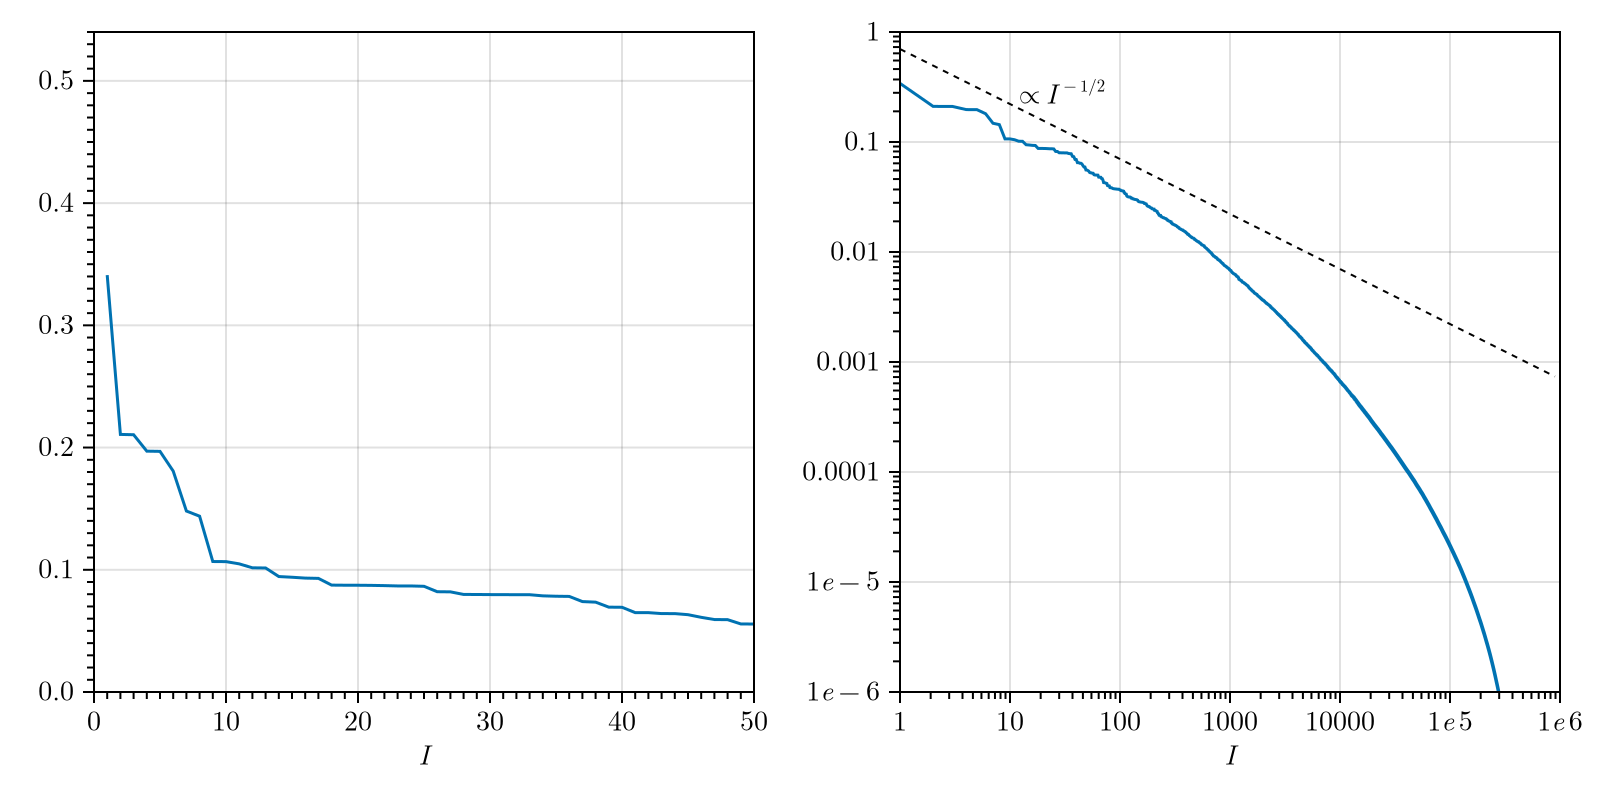

In [9]:

lists = [elements_list]


fig = Figure(; size = (800, 400));

ax2 = Axis(
	fig[1, 2],
	limits = (1, 1e6, 1e-6, 1),
	ytickformat = int_powers_of_10_scientific_LaTeX,
	xtickformat = int_powers_of_10_scientific_LaTeX,
	xlabel = L"I",
	yscale = log10,
	xscale = log10,
	yminorticksvisible = true,
	yminorticks = IntervalsBetween(10),
	xminorticksvisible = true,
	xminorticks = IntervalsBetween(10),
)
ax2.aspect = 1

ax1 = Axis(
	fig[1, 1],
	limits = (0, 50, 0, 0.54),
	yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5],
	xticks = [0, 10, 20, 30, 40, 50],
	ytickformat = float_scientific_LaTeX,
	xtickformat = int_LaTeX,
	xlabel = L"I",
	yminorticksvisible = true,
	yminorticks = IntervalsBetween(10),
	xminorticksvisible = true,
	xminorticks = IntervalsBetween(10),
)
ax1.aspect = 1

cnt = 1
for lst in lists
	tmp = lst .|> x -> x[2]
	tmp = tmp[abs.(tmp).>1e-6]
	lines!(ax2, abs.(tmp))
	#cnt += 1
end

cnt = 1
for lst in lists
	tmp = lst .|> x -> x[2]
	tmp = tmp[abs.(tmp).>0]
	lines!(ax1, abs.(tmp)[1:50])
	cnt += 1
end


n = [1, 900000];
lines!(ax2, n, n .|> x -> 0.7 * x^(-1 / 2), linestyle = :dash, color = :black, linewidth = 1)

text!(ax2, 12, 0.2; text = L"\propto I^{-1/2}")

fig

## Step 4: Compute Eigenvalues of the RG Jacobian

Now we compute the spectrum of the linearized Gilt-TNR map at the fixed point tensor. The eigenvalues correspond to CFT scaling dimensions via λ = 2^Δ.

**Expected for c=1/2 CFT (same as Ising):**
- λ ≈ 3.668 → Δ = 1/8 (magnetization σ)
- λ ≈ 2.0 → Δ = 1 (energy ε)
- λ ≈ ±1.0 → Δ = 2 (stress tensor T, T̄)

In [ ]:
# Run the φ⁴ eigensystem computation
# Note: This may take several minutes
run(`julia --project scripts/phi4_eigensystem.jl --chi $chi --mu_sq $mu_sq --lam $lam`)

## Step 5: Newton Method for High-Precision Fixed Point

The Newton method refines the fixed point tensor to high precision. First, we need to set up for the rotating algorithm which is used for Newton convergence.

In [ ]:
# For φ⁴, we need to find the critical point for the rotating algorithm
# This step can be skipped initially - we'll use the same mu_sq

gilt_pars_rotate = Dict(
	"gilt_eps" => gilt_eps,
	"cg_chis" => collect(1:chi),
	"cg_eps" => cg_eps,
	"verbosity" => 0,
	"rotate" => true,  # Enable rotation
)

@info "Using rotating algorithm with μ² = $mu_sq"

## Run Newton Method

Now we run the Newton method to find the exact fixed point tensor. This uses a low-rank Jacobian approximation with `s` eigenvectors.

In [ ]:
# Run Newton method for φ⁴
# s = number of eigenvectors for Jacobian approximation
s = 54
run(`julia --project --threads 20 scripts/phi4_newton.jl --chi $chi --mu_sq $mu_sq --lam $lam --eigensystem_size_for_jacobian $s`)

## Newton Convergence Plot

The Newton method should converge to machine precision. Below we plot the step sizes to verify convergence.

In [ ]:
ϕ=(1+sqrt(5))/2
fig = Figure(; size = (ϕ * 400, 400));

ax = Axis(fig[1, 1],
	yscale = log10,
	xlabel = L"\text{Newton iteration } m",
	ylabel = L"||A_{(m)}-A_{(m+1)}||",
	limits = (-0.5, 31, 10^(-10), 10^(-2)),
	xminorticksvisible = true,
	yminorticksvisible = true,
	xminorticks = IntervalsBetween(10),
	yminorticks = IntervalsBetween(10),
	ytickformat = int_powers_of_10_scientific_LaTeX,
	xtickformat = int_LaTeX,
	yticks = vcat([0.01], 10.0 .^ ([-3, -4, -5, -6, -7, -8, -9, -10])),
	title = "φ⁴ Newton Method Convergence"
);
ax.aspect = 1

# Load φ⁴ Newton results
newton_file = "newton/phi4_rotate=true_$(chi)_$(gilt_eps)_$(cg_eps)_mu_sq=$(mu_sq)_jac_approximation_rank=$s.data"
if isfile(newton_file)
	dat = deserialize(newton_file)
	A_hist = dat["A_newton"]
	lines!(ax, 0:(length(A_hist)-2), variation(A_hist) .|> norm, color =:black, label = "s=$s")
	scatter!(ax, 0:(length(A_hist)-2), variation(A_hist) .|> norm, label= "s=$s")
else
	@warn "Newton results file not found: $newton_file"
	@info "Run the Newton method cell first (cell 24)"
end

fig